In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt

In [2]:
TFtot = 2000
kon = 0.0016399 
koff_invert = 0.34393
koff_amp = 0.34393 / 2
kbasal_invert = 0.02612 
kbasal_amp = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

p_amp =  kon, TFtot, koff_amp, kbasal_amp, kmax, n, Kd, kdegR, ktrans, kdegP
p_invert = kon, TFtot, koff_invert, kbasal_invert, kmax, n, Kd, kdegR, ktrans, kdegP

Kd_scaled = Kd / TFtot
kmax_scaled_amp = kmax * kdegR / (kbasal_amp + kmax)
kbasal_scaled_amp = kbasal_amp * kdegR / (kbasal_amp + kmax)
k_alpha_amp = kon * 1000 / koff_amp
k_beta_amp = koff_amp 

p_scaled_amp = k_alpha_amp, k_beta_amp, kbasal_scaled_amp, kmax_scaled_amp, n, Kd_scaled, kdegR


Kd_scaled = Kd / TFtot
kmax_scaled_invert = kmax * kdegR / (kbasal_invert + kmax)
kbasal_scaled_invert = kbasal_invert * kdegR / (kbasal_invert + kmax)
k_alpha_invert = kon * 1000 / koff_invert
k_beta_invert = koff_invert

p_scaled_invert = k_alpha_invert, k_beta_invert, kbasal_scaled_invert, kmax_scaled_invert, n, Kd_scaled, kdegR


In [92]:
def khammash_ode_scaled(t,x,p_scaled,I):
    if callable(I):
        I = I(t)

    # Parameters
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = p_scaled

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])

    # k_alpha = kon / koff
    # k_beta = koff

    dTFondt = (I * k_alpha * (1 - TFon) - TFon) * k_beta
    # dTFondt = I * kon * (1 - TFon) - koff * TFon
    dmRNAdt = kbasal_scaled + kmax_scaled * (TFon ** n) / ((Kd_scaled ** n) + (TFon ** n)) - kdegR * mRNA

    return [dTFondt, dmRNAdt]


def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])
    mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = I * kon * (TFtot - (TFon  * TFtot)) - koff * (TFon  * TFtot)
    dmRNAdt = kbasal + kmax * ((TFon  * TFtot) ** n) / ((Kd ** n) + ((TFon  * TFtot) ** n)) - kdegR * mRNA

    dTFondt = dTFondt / TFtot
    dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax)

    return [dTFondt, dmRNAdt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,-1] - x[:])
    return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def fsolve_func_scaled(x,period,I,max_step, p_scaled):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    return (sol.y[:,-1] - x[:])
    # return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, p_scaled, x_guess=None):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [u,u]

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    # try:
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step), xtol=1e-9, maxiter=5000)
    # except:
    #     print('first one failed')
    #     x_guess = [u,u]
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step/10), xtol=1e-9, maxiter=5000)
    # steady = sol


    sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step, p_scaled), tol=1e-9)
    if not sol.success:
        x_guess = [u,u]
        sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step, p_scaled), tol=1e-9)

    steady = np.maximum(sol.x,[0,0])
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=steady, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    steady = np.trapz(sol.y, x=sol.t) / period

    return steady#, sol.success, sol.message, sol.fun

def opto_growth(t,x,p, control_p, prod_p, u0, mRNA_funs, ratio_sp=None, od_sp=None):

    # Parameters
    kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp = p

    k_r1, K_r1, k_r2, K_r2 = prod_p

    mRNA_inv_fun, mRNA_amp_fun = mRNA_funs

    x_guess = x
    global setpoint_amp, setpoint_invert
    # if setpoint is None:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess)
    # else:
    #     out = setpoint
    # if ier != 1:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess=None)

    tau_mRNA = 1 / kdegR

    # Variables
    mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, Int, Prod, X_invert, X_amp, X1X2_ratio, I = x
    # mRNA_blind = 1

    mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S)
    mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S)

    S0 = 20
    if od_sp is None:
        d = 0
    else:
        d = np.asarray([(mu_x_invert * X_invert + mu_x_amp * X_amp) / (X_invert + X_amp)]).flatten()
        # print((d.shape))
        d[(X_invert + X_amp) < od_sp] = 0
        # if (X_invert + X_amp) < od_sp:
        #     d = 0
        # elif (X_invert + X_amp) > od_sp:
        #     d = d #* (X_invert + X_amp)/od_sp

    dSdt = - (mu_x_invert / Y) * X_invert - (mu_x_amp / Y) * X_amp + d * (S0 - S) - X_invert * k_r1 * S / (K_r1 + S)
    dIntdt = k_r1 * X_invert * S / (K_r1 + S) - k_r2 * X_amp * Int / (K_r2 + Int) - d * Int
    dProddt = k_r2 * X_amp * Int / (K_r2 + Int) - d * Prod
    dX_invert_dt = mu_x_invert * X_invert - d * X_invert
    dX_amp_dt = mu_x_amp * X_amp - d * X_amp

    X1X2_ratio = X_invert / X_amp
    dX1X2_ratio = (1/X_amp) * dX_invert_dt - (X_invert/X_amp**2) * dX_amp_dt

    if ratio_sp is None:
        u = u0
        dIdt = 0
    else:
        K_P, K_I, I_clip, K_D = control_p
        if callable(ratio_sp):
            target = ratio_sp(t)
        u = np.log10(u0) + K_P * (X1X2_ratio - target) + K_I * I + K_D * dX1X2_ratio
        u = np.clip(u, -5, 0)
        u = 10 ** u
        dIdt = np.clip((X1X2_ratio - target),-I_clip,I_clip) - k_I_decay * I

    dmRNA_invert_dt = (mRNA_inv_fun(u) - mRNA_invert) / tau_mRNA
    dmRNA_amp_dt = (mRNA_amp_fun(u) - mRNA_amp) / tau_mRNA

    # Enz_opto = Enz_opto / ((mu_max_opto + kdegP) / ktrans)
    ktrans_scaled_invert = ktrans  * ((mu_max_invert + kdegP) / ktrans)
    ktrans_scaled_PDC_invert = ktrans  * ((mu_max_invert + kdegPPDC) / ktrans)
    
    dRepdt = ktrans_scaled_invert * mRNA_invert * S / (Ks + S) - (kdegP + mu_x_invert) * Rep

    dEnz_invert_dt = np.zeros(np.array(t).shape)
    
    dEnz_invert_dt[Rep < 0] = (ktrans_scaled_PDC_invert * S / (Ks + S) - (kdegPPDC + mu_x_invert) * Enz_invert)[Rep < 0]
    dEnz_invert_dt[Rep >= 0] = (ktrans_scaled_PDC_invert * (K_Rep ** n_Rep / (K_Rep ** n_Rep + Rep ** n_Rep)) * S / (Ks + S) - (kdegPPDC + mu_x_invert) * Enz_invert)[Rep >= 0]

    # dEnz_optodt = dEnz_optodt * ((mu_max_opto + kdegP) / ktrans)

    # Enz_blind = Enz_blind / ((mu_max_blind + kdegP) / ktrans)
    ktrans_scaled_amp = ktrans  * ((mu_max_amp + kdegP) / ktrans)
    ktrans_scaled_PDC_amp = ktrans  * ((mu_max_amp + kdegPPDC) / ktrans)
    
    dAmpdt = ktrans_scaled_amp * mRNA_amp * S / (Ks + S) - (kdegP + mu_x_amp) * Amp

    dEnz_amp_optodt = np.zeros(np.array(t).shape)
    dEnz_amp_optodt[Amp < 0] = (- (kdegPPDC + mu_x_amp) * Enz_amp)[Amp < 0]
    dEnz_amp_optodt[Amp >= 0] = (ktrans_scaled_PDC_amp * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp)[Amp >= 0]
    # dEnz_blind_optodt = dEnz_blind_optodt * ((mu_max_blind + kdegP) / ktrans)
    
    # print('=================================================')
    # print(x)
    # print([dmRNA_invert_dt, dmRNA_amp_dt, dRepdt, dAmpdt, dEnz_invert_dt, dEnz_amp_optodt, dSdt, dIntdt, dProddt, dX_invert_dt, dX_amp_dt, dX1X2_ratio, dIdt])

    return [dmRNA_invert_dt, dmRNA_amp_dt, dRepdt, dAmpdt, dEnz_invert_dt, dEnz_amp_optodt, dSdt, dIntdt, dProddt, dX_invert_dt, dX_amp_dt, dX1X2_ratio, dIdt]


In [4]:
# _, _, _, _, _, _, _, _, _, _, _, dX1X2_ratio, _ = opto_growth(t_arr, sol.y, optogrowth_p, control_p, prod_p, u0, mRNA_funs, ratio_sp, od_sp)

In [5]:
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.00
K_Rep = 0.01
K_Amp = 0.99

mu_max_invert = 0.0233 / 20
mu_max_amp = 0.014 / 20

# mu_max = mu_max_opto
Ks = 1
Y = 0.5

NameError: name 'kdegPPDC' is not defined

In [7]:
from tqdm import tqdm

if False:

    u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,100))))

    # u_arr = np.flip(10 ** np.linspace(-1,0,100))
    Enz_arr = np.zeros(u_arr.size)
    mRNA_arr_amp = np.zeros(u_arr.size)
    mRNA_arr_invert = np.zeros(u_arr.size)

    setpoint_amp = None
    setpoint_invert = None

    for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
        # print(u)
        period = 100 / 60
        Imax = 1
        setpoint_amp = steady_mRNA_solve(u, period, Imax, p_scaled_amp, x_guess=setpoint_amp)
        # print(setpoint)
        mRNAss = setpoint_amp[1]
        mRNA_arr_amp[i] = mRNAss

        setpoint_invert = steady_mRNA_solve(u, period, Imax, p_scaled_invert, x_guess=setpoint_invert)

        mRNAss = setpoint_invert[1]
        mRNA_arr_invert[i] = mRNAss


100%|██████████| 101/101 [08:15<00:00,  4.91s/it]


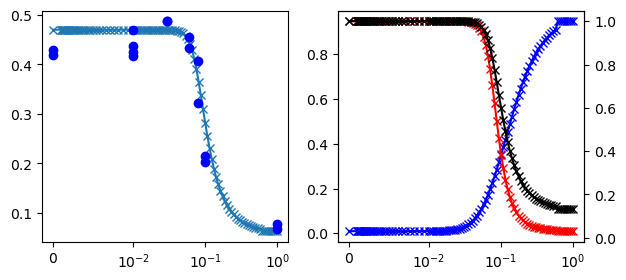

In [9]:
# Inverted Circuit

# u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,100))))

kdegR = 0.042116
ktrans = 1.4514
kdegP = np.log(2) / (6 * 60)
kdegPPDC = np.log(2) / (12 * 60)
K_Rep = 0.3
n_Rep = 3
mu_max_invert = 0.47 / 60


import matplotlib.pyplot as plt

ktrans_scaled = ktrans  * ((mu_max_invert + kdegP) / ktrans)
ss_Rep = - (1 / (2 * mu_max_invert)) * (kdegP - np.sqrt(4 * mRNA_arr_invert * mu_max_invert * ktrans_scaled + kdegP ** 2))
ktrans_scaled_PDC = ktrans  * ((mu_max_invert + kdegPPDC) / ktrans)
# ktrans_scaled_invert = ktrans  * ((mu_max_invert + kdegP) / ktrans)
# dEnz_invert_dt = ktrans_scaled_invert * (K_Rep / (K_Rep + Rep)) * S / (Ks + S) - (kdegP + mu_x_invert) * Enz_invert
ss_Enz = - (1 / (2 * mu_max_invert)) * (kdegPPDC - np.sqrt(4 * (K_Rep ** n_Rep / (K_Rep ** n_Rep + ss_Rep ** n_Rep)) * mu_max_invert * ktrans_scaled_PDC + kdegPPDC ** 2))

mu_arr_invert = ss_Enz * mu_max_invert * 60

# Real Data
mu_SGy104_1 = np.array([0.429016493, 0.419454997, 0.425278485, 0.468815929, 0.214066814, 0.202848859, 0.077447387, 0.067285511, 0.487083379, 0.487241995,
0.436233624, 0.416734105, 0.433773399, 0.4552301, 0.406627518, 0.322757789])
mu_SGy104_1_lights = np.array([0, 0, 0.01, 0.01, 0.1, 0.1, 1, 1, 0.03, 0.03, 0.01, 0.01, 0.06, 0.06, 0.08, 0.08])


fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_invert, '-x', label='mu')
ax.plot(mu_SGy104_1_lights, mu_SGy104_1, 'ob', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, ss_Rep, '-bx', label='mu')
ax.set_xscale('symlog', linthresh=0.01)
ax2 = ax.twinx()
ax2.plot(u_arr, (K_Rep ** n_Rep / (K_Rep ** n_Rep + ss_Rep ** n_Rep)), '-rx', label='mu')
ax2.plot(u_arr, ss_Enz, '-kx', label='mu')


# print(max(mu_arr_invert))
# print(min(mu_arr_invert))
# print(- (1 / (2 * mu_max_invert)) * (kdegP - np.sqrt(4 * (K_Rep / (K_Rep + ss_Rep[0])) * mu_max_invert * ktrans_scaled + kdegP ** 2)))

# print(ss_Rep)
# print(u_arr)


0.4310397346847467
0.06652894732805258


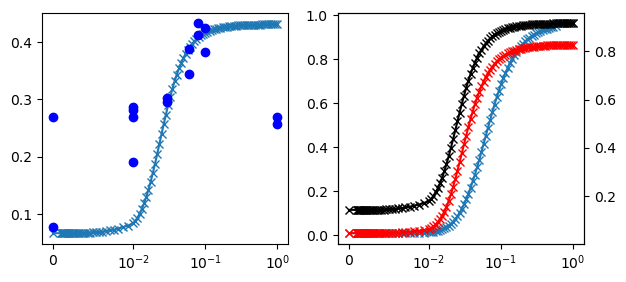

In [10]:
# Amp Circuit
K_Amp = 0.2
mu_max_amp = 0.47 / 60
n_Amp = 1.1

import matplotlib.pyplot as plt

# dAmpdt = ktrans_scaled_amp * mRNA_amp * S / (Ks + S) - (kdegP + mu_x_amp) * Amp
# dEnz_amp_optodt = ktrans_scaled_PDC_amp * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp

ktrans_scaled = ktrans  * ((mu_max_amp + kdegP) / ktrans)
ss_Amp = - (1 / (2 * mu_max_amp)) * (kdegP - np.sqrt(4 * mRNA_arr_amp * mu_max_amp * ktrans_scaled + kdegP ** 2))
ktrans_scaled_PDC = ktrans  * ((mu_max_amp + kdegPPDC) / ktrans)
ss_Enz = - (1 / (2 * mu_max_amp)) * (kdegPPDC - np.sqrt(4 * (ss_Amp ** n_Amp / (K_Amp ** n_Amp + ss_Amp ** n_Amp)) * mu_max_amp * ktrans_scaled_PDC + kdegPPDC ** 2))

mu_arr_amp = ss_Enz * mu_max_amp * 60

# Real Data
mu_SGy128_4 = np.array([0.07654071, 0.26858448, 0.28688688, 0.19000113, 0.3834206 ,
       0.42503585, 0.25622547, 0.26932193, 0.30298274, 0.29615459,
       0.28158447, 0.26857221, 0.34449419, 0.38737338, 0.412247  ,
       0.43290314])
mu_SGy128_4_lags = np.array([ 0.        , 39.88279932, 19.98011315, 14.4137813 ,  0.        ,
        2.18260617,  0.        ,  1.21280087, 10.40812555,  7.77763666,
       21.22069601, 19.70771971,  1.68719277,  3.11811039,  2.52691981,
        2.30179095])
mu_SGy128_4_lights = np.array([0, 0, 0.01, 0.01, 0.1, 0.1, 1, 1, 0.03, 0.03, 0.01, 0.01, 0.06, 0.06, 0.08, 0.08])


fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_amp, '-x', label='mu')
ax.plot(mu_SGy128_4_lights, mu_SGy128_4, 'ob', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
ax.plot(u_arr, ss_Amp, '-x', label='mu')
ax.set_xscale('symlog', linthresh=0.01)
ax2 = ax.twinx()
ax2.plot(u_arr, (ss_Amp / (K_Amp + ss_Amp)), '-rx', label='mu')
ax2.plot(u_arr, ss_Enz, '-kx', label='mu')


print(max(mu_arr_amp))
print(min(mu_arr_amp))

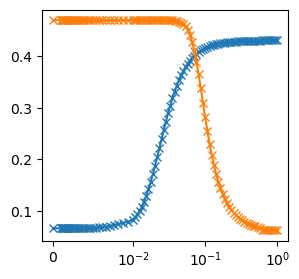

In [11]:
fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(121)
ax.plot(u_arr, mu_arr_amp, '-x', label='mu_amp')
ax.plot(u_arr, mu_arr_invert, '-x', label='mu_invert')
ax.set_xscale('symlog', linthresh=0.01)

In [168]:
X10 = ratio_sp(0)[0] * 2 / (1 + ratio_sp(0)[0])
X20 = 2 - X10
x_init = np.array([u, u, u, u, 1-u, u, 20, 0, 0, X10, X20, X10/X20, 0])
X10

TypeError: 'NoneType' object is not callable

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0
The solver successfully reached the end of the integration interval.
True


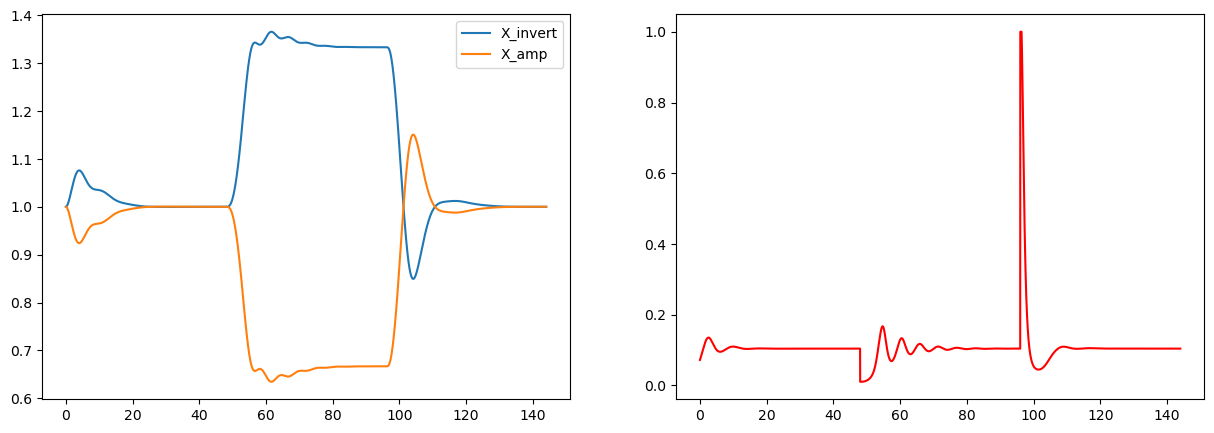

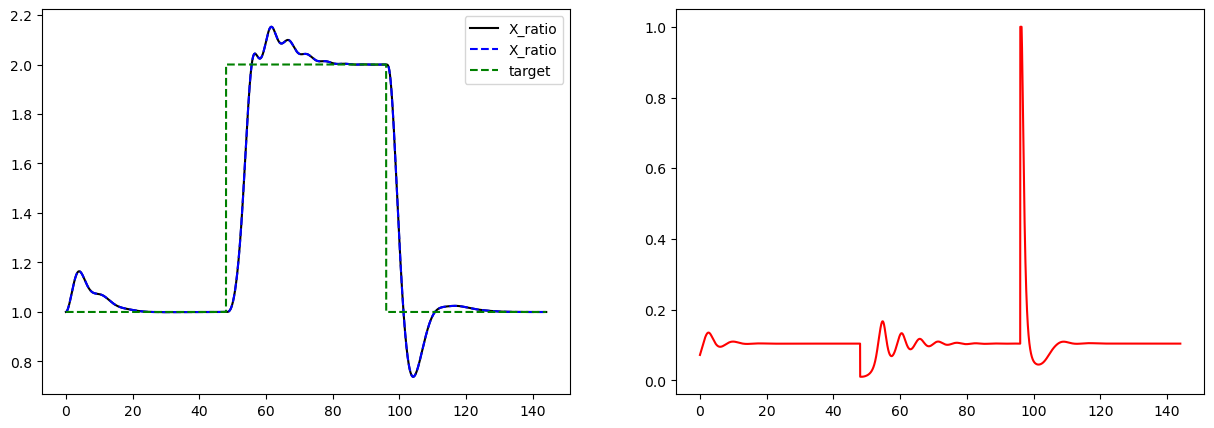

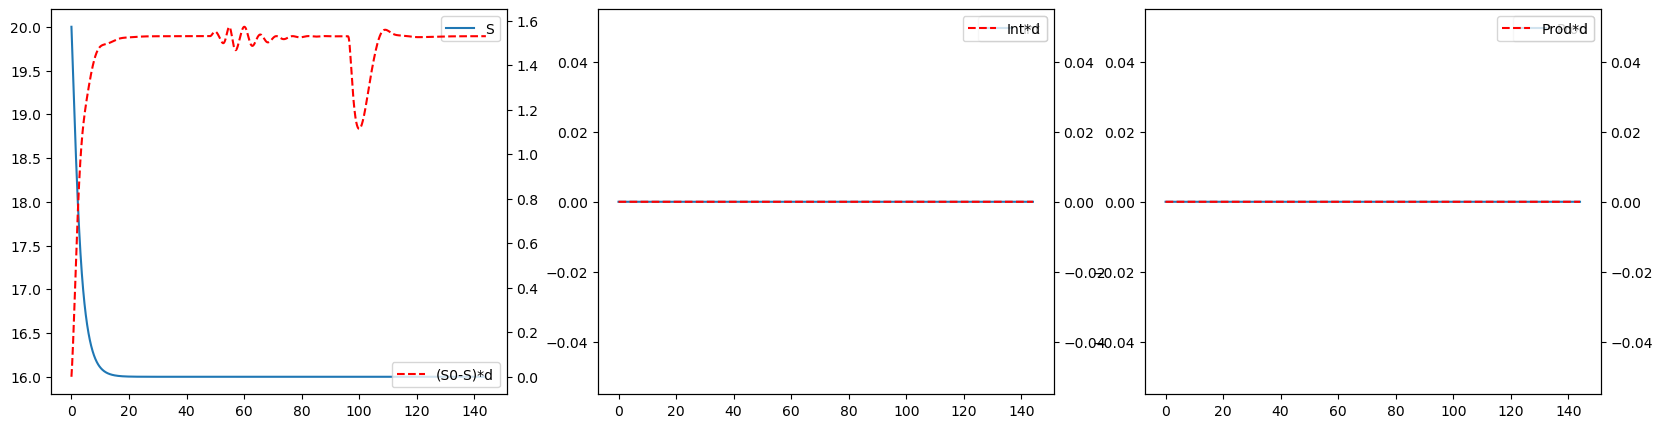

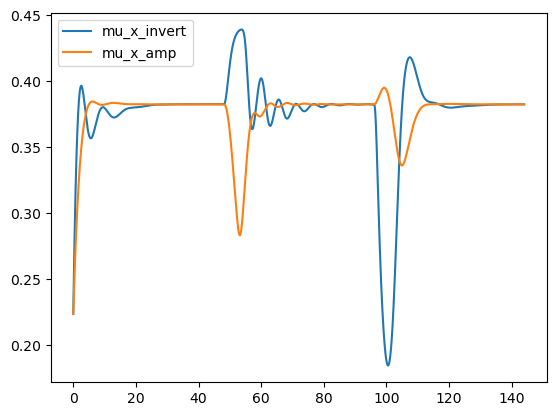

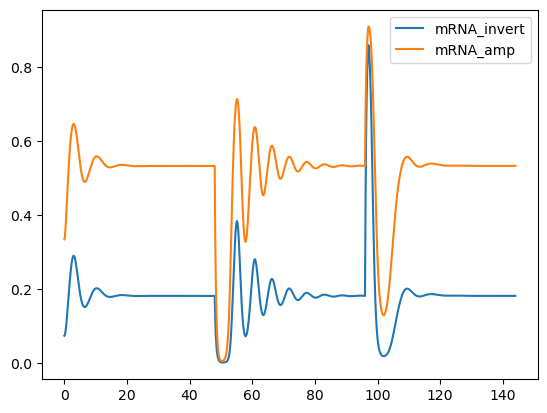

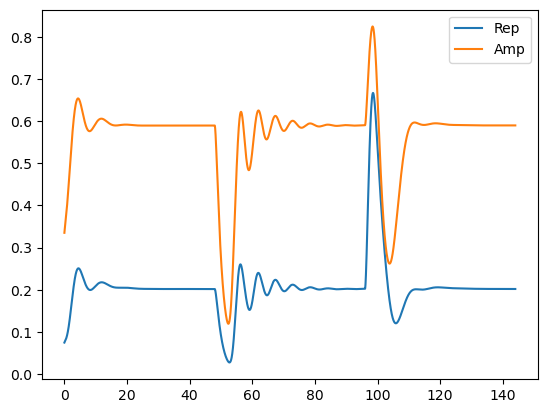

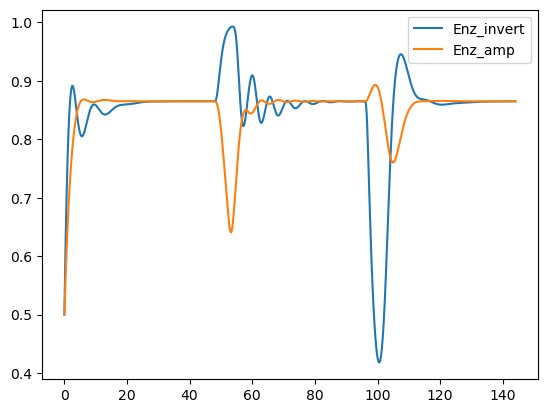

In [101]:
from scipy.interpolate import interp1d

# kdegR = 0.042116
# ktrans = 1.4514
# kdegP = 0.1
# K_Rep = 0.05
# K_Amp = 0.99
# n_Rep = 4
# n_Amp = 4
# kdegPPDC = 0

# mu_max_invert = 0.45 / 60
# mu_max_amp = 0.45 / 60

# # mu_max = mu_max_opto
# Ks = 1
# Y = 0.5


t_final = 144

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp


# def opto_growth(t,x,p, control_p, u0, mRNA_funs, ratio_sp=None, od_sp=None):
K_P = 1.0
K_I = 0.002
I_clip = 0.2
K_D = 150
control_p = K_P, K_I, I_clip, K_D

k_r1 = 0.0
K_r1 = 1
k_r2 = 0.0
K_r2 = 1
prod_p = k_r1, K_r1, k_r2, K_r2


tspan = [0, t_final*60]
u0 = 0.072
u = u0
mRNA_invert_fun = lambda  u: interp1d(u_arr, mRNA_arr_invert)(u)
mRNA_amp_fun = lambda  u: interp1d(u_arr, mRNA_arr_amp)(u)
mRNA_funs = mRNA_invert_fun, mRNA_amp_fun
od_sp = 2

def ratio_sp(t):
    t = np.array(t)
    output = np.zeros(t.size)
    output[t < 60*48] = 1.0
    output[t >= 60*48] = 2.0
    output[t >= 60*96] = 1.0
    return output

X10 = ratio_sp(0)[0] * 2 / (1 + ratio_sp(0)[0])
X20 = 2 - X10
x_init = np.array([mRNA_invert_fun(u), mRNA_amp_fun(u), mRNA_invert_fun(u), mRNA_amp_fun(u), 0.5, 0.5, 20, 0, 0, X10, X20, X10/X20, 0])

period = 100 / 60
Imax = 1

setpoint_amp = steady_mRNA_solve(u0, period, Imax, p_scaled_amp, x_guess=setpoint_amp)
setpoint_invert = steady_mRNA_solve(u0, period, Imax, p_scaled_invert, x_guess=setpoint_invert)

# print('my setpoint')
# print(setpoint)

I = lambda t: I_fun_base(t, u, period, Imax)

if u0 > 0:
    max_step = u0*period
else:
    max_step = period / 10

sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p, control_p, prod_p, u0, mRNA_funs, ratio_sp, od_sp),
                    rtol=1e-9, atol=1e-12, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0001,
                    # max_step=max_step,
                    )
x_init = sol.y[:,-1]

print(sol.status)
print(sol.message)
print(sol.success)

mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, Int_x, Prod_x, X_invert_x, X_amp_x, X1X2_ratio_x, I_x = sol.y

mRNA_invert = mRNA_invert_x
mRNA_amp = mRNA_amp_x
Rep = Rep_x
Amp = Amp_x
Enz_invert = Enz_invert_x
Enz_amp = Enz_amp_x
S = S_x
Int = Int_x
Prod = Prod_x
X_invert = X_invert_x
X_amp = X_amp_x
X1X2_ratio = X1X2_ratio_x
I = I_x
t_arr = sol.t

_, _, _, _, _, _, _, _, _, _, _, dX1X2_ratio, _ = opto_growth(t_arr, sol.y, optogrowth_p, control_p, prod_p, u0, mRNA_funs, ratio_sp, od_sp)


mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

u_plot = np.log10(u0) + K_P * (X_invert/X_amp - ratio_sp(t_arr)) + K_I * I + K_D * dX1X2_ratio
u_plot = np.clip(u_plot, -5, 0)
u_plot = 10 ** u_plot

fig = plt.figure(facecolor='white', figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(t_arr/60, X_invert, label='X_invert')
ax.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()
ax = fig.add_subplot(122)
ax.plot(t_arr/60, u_plot, 'r', label='u')

fig = plt.figure(facecolor='white', figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(t_arr/60, X_invert/X_amp, 'k-', label='X_ratio')
ax.plot(t_arr/60, X1X2_ratio, 'b--', label='X_ratio')
ax.plot(t_arr/60, ratio_sp(t_arr), 'g--', label='target')
plt.legend()
ax = fig.add_subplot(122)
ax.plot(t_arr/60, u_plot, 'r', label='u')

d = (mu_x_invert * X_invert + mu_x_amp * X_amp) / (X_invert + X_amp)
S0 = 20

fig = plt.figure(facecolor='white', figsize=(20,5))
ax = fig.add_subplot(131)
ax.plot(t_arr/60, S, label='S')
plt.legend()
ax2 = ax.twinx()
ax2.plot(t_arr/60, (S0-S)*d, 'r--', label='(S0-S)*d')
plt.legend()

ax = fig.add_subplot(132)
ax.plot(t_arr/60, Int, label='Int')
plt.legend()
ax2 = ax.twinx()
ax2.plot(t_arr/60, Int*d, 'r--', label='Int*d')
plt.legend()

ax = fig.add_subplot(133)
ax.plot(t_arr/60, Prod, label='Prod')
plt.legend()
ax2 = ax.twinx()
plt.legend()
ax2.plot(t_arr/60, Prod*d, 'r--', label='Prod*d')
plt.legend()


plt.figure(facecolor='white')
plt.plot(t_arr/60, mu_x_invert, label='mu_x_invert')
plt.plot(t_arr/60, mu_x_amp, label='mu_x_amp')
plt.legend()


plt.figure(facecolor='white')
plt.plot(t_arr/60, mRNA_invert, label='mRNA_invert')
plt.plot(t_arr/60, mRNA_amp, label='mRNA_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Rep, label='Rep')
plt.plot(t_arr/60, Amp, label='Amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Enz_invert, label='Enz_invert')
plt.plot(t_arr/60, Enz_amp, label='Enz_amp')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0
The solver successfully reached the end of the integration interval.
True


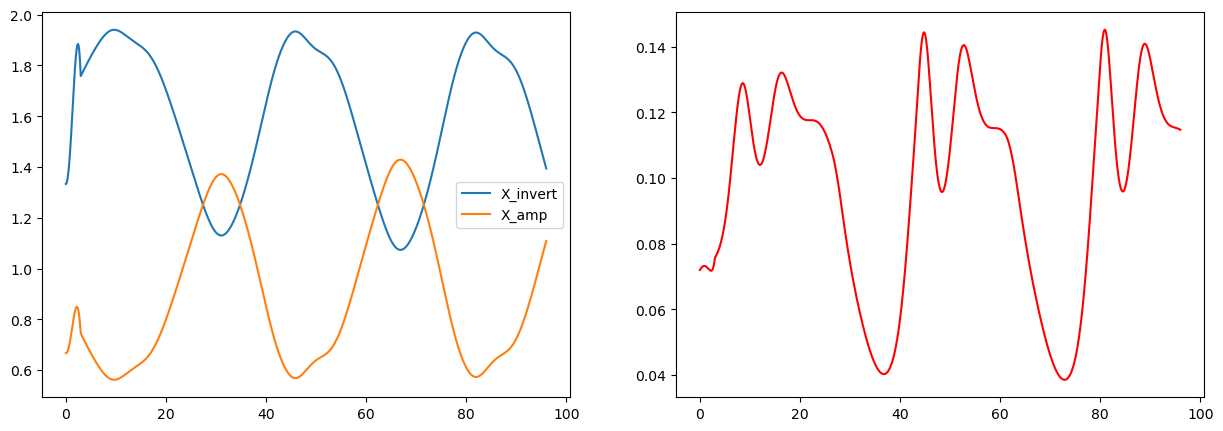

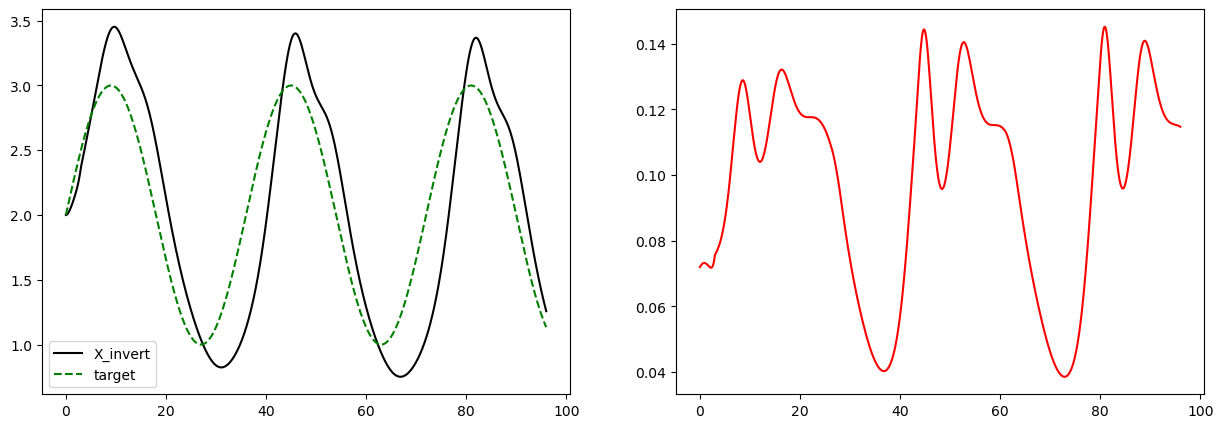

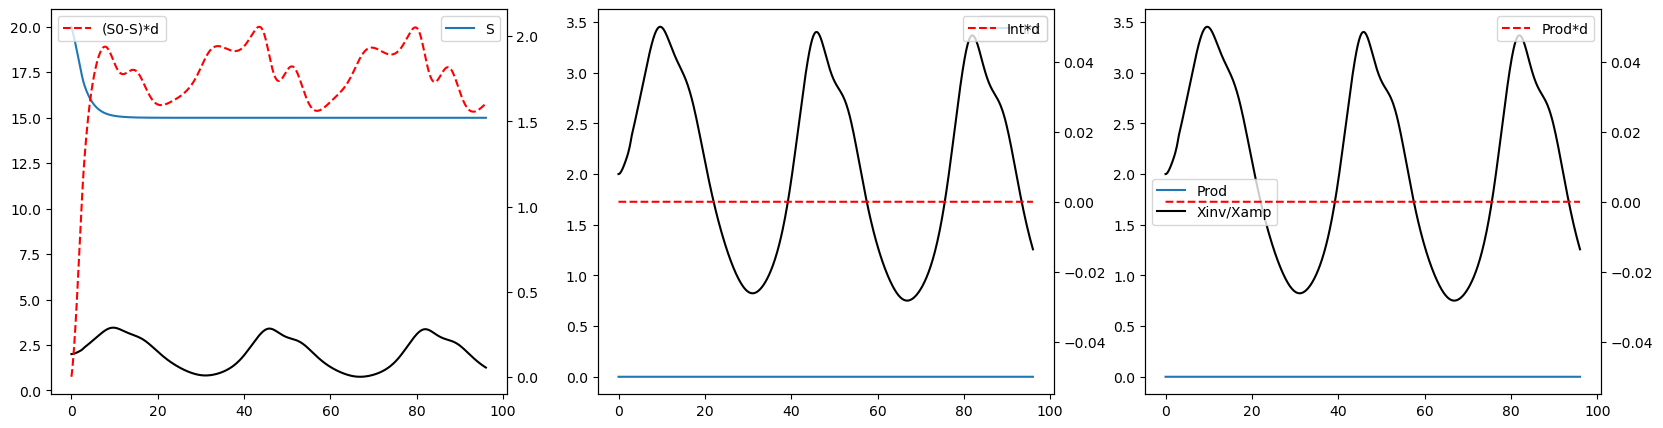

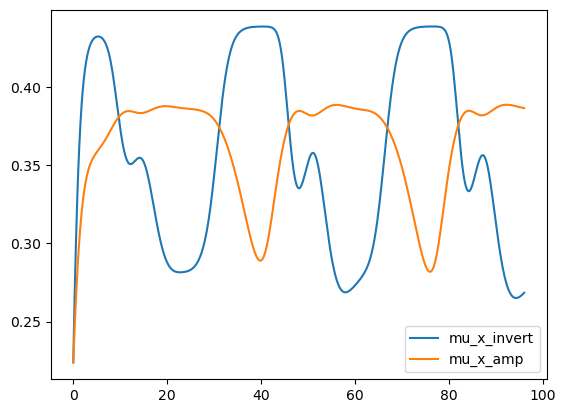

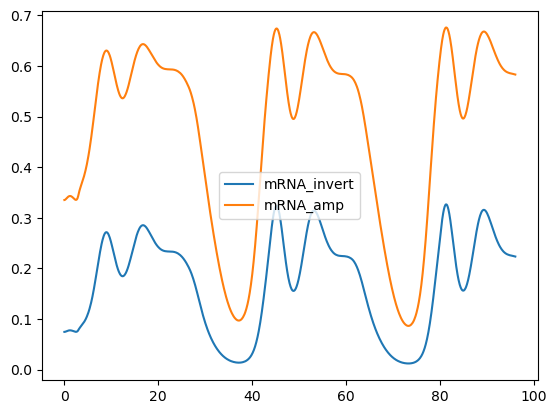

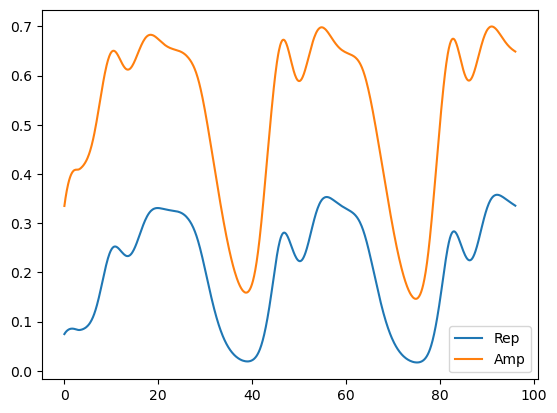

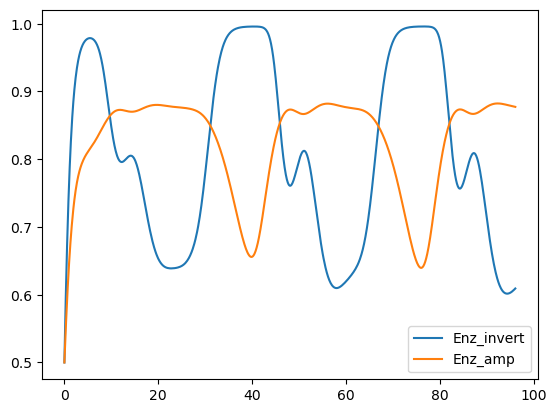

In [145]:
from scipy.interpolate import interp1d

# kdegR = 0.042116
# ktrans = 1.4514
# kdegP = 0.1
# K_Rep = 0.05
# K_Amp = 0.99
# n_Rep = 4
# n_Amp = 4
# kdegPPDC = 0

# mu_max_invert = 0.45 / 60
# mu_max_amp = 0.45 / 60

# # mu_max = mu_max_opto
# Ks = 1
# Y = 0.5


t_final = 96

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp


# def opto_growth(t,x,p, control_p, u0, mRNA_funs, ratio_sp=None, od_sp=None):
K_P = 0.5
K_I = 0.002
I_clip = 0.1
K_D = 40
control_p = K_P, K_I, I_clip, K_D

tspan = [0, t_final*60]
u0 = 0.072
u = u0
mRNA_invert_fun = lambda  u: interp1d(u_arr, mRNA_arr_invert)(u)
mRNA_amp_fun = lambda  u: interp1d(u_arr, mRNA_arr_amp)(u)
mRNA_funs = mRNA_invert_fun, mRNA_amp_fun
od_sp = 2

def ratio_sp(t):
    t = np.array(t)
    output = np.sin(2*np.pi/(36*60)*t) + 2
    return output

# x_init = [u0, u0, u0, u0, 1-u0, u0, 20, 1, 1, 0]
X10 = ratio_sp(0) * 2 / (1 + ratio_sp(0))
X20 = 2 - X10
x_init = np.array([mRNA_invert_fun(u), mRNA_amp_fun(u), mRNA_invert_fun(u), mRNA_amp_fun(u), 0.5, 0.5, 20, 0, 0, X10, X20, X10/X20, 0])

period = 100 / 60
Imax = 1

setpoint_amp = steady_mRNA_solve(u0, period, Imax, p_scaled_amp, x_guess=setpoint_amp)
setpoint_invert = steady_mRNA_solve(u0, period, Imax, p_scaled_invert, x_guess=setpoint_invert)

# print('my setpoint')
# print(setpoint)

I = lambda t: I_fun_base(t, u, period, Imax)

if u0 > 0:
    max_step = u0*period
else:
    max_step = period / 10

sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p, control_p, prod_p, u0, mRNA_funs, ratio_sp, od_sp),
                    rtol=1e-6, atol=1e-9, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0001,
                    # max_step=max_step,
                    )
x_init = sol.y[:,-1]

print(sol.status)
print(sol.message)
print(sol.success)

mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, Int_x, Prod_x, X_invert_x, X_amp_x, X1X2_ratio_x, I_x = sol.y

mRNA_invert = mRNA_invert_x
mRNA_amp = mRNA_amp_x
Rep = Rep_x
Amp = Amp_x
Enz_invert = Enz_invert_x
Enz_amp = Enz_amp_x
S = S_x
Int = Int_x
Prod = Prod_x
X_invert = X_invert_x
X_amp = X_amp_x
X1X2_ratio = X1X2_ratio_x
I = I_x
t_arr = sol.t

_, _, _, _, _, _, _, _, _, _, _, dX1X2_ratio, _ = opto_growth(t_arr, sol.y, optogrowth_p, control_p, prod_p, u0, mRNA_funs, ratio_sp, od_sp)

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

u_plot = np.log10(u0) + K_P * (X_invert/X_amp - ratio_sp(t_arr)) + K_I * I + K_D * dX1X2_ratio
u_plot = np.clip(u_plot, -5, 0)
u_plot = 10 ** u_plot

fig = plt.figure(facecolor='white', figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(t_arr/60, X_invert, label='X_invert')
ax.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()
ax = fig.add_subplot(122)
ax.plot(t_arr/60, u_plot, 'r', label='u')

fig = plt.figure(facecolor='white', figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(t_arr/60, X_invert/X_amp, 'k-', label='X_invert')
ax.plot(t_arr/60, ratio_sp(t_arr), 'g--', label='target')
plt.legend()
ax = fig.add_subplot(122)
ax.plot(t_arr/60, u_plot, 'r', label='u')

d = (mu_x_invert * X_invert + mu_x_amp * X_amp) / (X_invert + X_amp)
S0 = 20

fig = plt.figure(facecolor='white', figsize=(20,5))
ax = fig.add_subplot(131)
ax.plot(t_arr/60, S, label='S')
plt.legend()
ax2 = ax.twinx()
ax2.plot(t_arr/60, (S0-S)*d, 'r--', label='(S0-S)*d')
ax.plot(t_arr/60, X_invert/X_amp, 'k-', label='Xinv/Xamp')
plt.legend()

ax = fig.add_subplot(132)
ax.plot(t_arr/60, Int, label='Int')
plt.legend()
ax2 = ax.twinx()
ax2.plot(t_arr/60, Int*d, 'r--', label='Int*d')
ax.plot(t_arr/60, X_invert/X_amp, 'k-', label='Xinv/Xamp')
plt.legend()

ax = fig.add_subplot(133)
ax.plot(t_arr/60, Prod, label='Prod')
ax.plot(t_arr/60, X_invert/X_amp, 'k-', label='Xinv/Xamp')
plt.legend()
ax2 = ax.twinx()
plt.legend()
ax2.plot(t_arr/60, Prod*d, 'r--', label='Prod*d')
plt.legend()


plt.figure(facecolor='white')
plt.plot(t_arr/60, mu_x_invert, label='mu_x_invert')
plt.plot(t_arr/60, mu_x_amp, label='mu_x_amp')
plt.legend()


plt.figure(facecolor='white')
plt.plot(t_arr/60, mRNA_invert, label='mRNA_invert')
plt.plot(t_arr/60, mRNA_amp, label='mRNA_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Rep, label='Rep')
plt.plot(t_arr/60, Amp, label='Amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Enz_invert, label='Enz_invert')
plt.plot(t_arr/60, Enz_amp, label='Enz_amp')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0
The solver successfully reached the end of the integration interval.
True
0
The solver successfully reached the end of the integration interval.
True


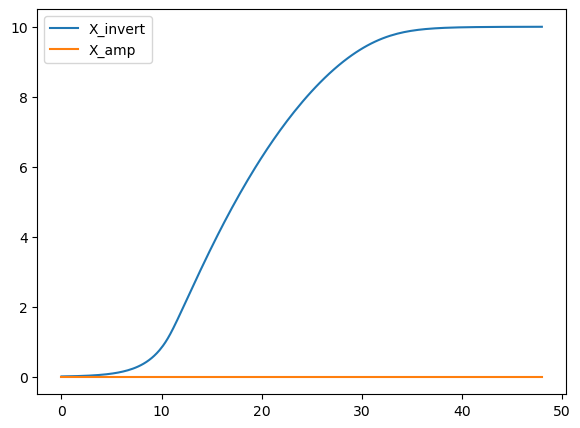

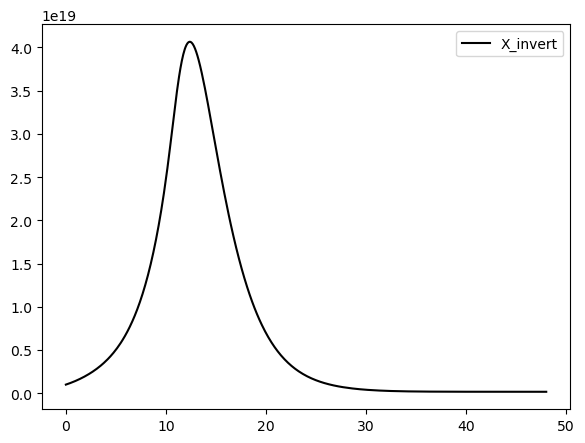

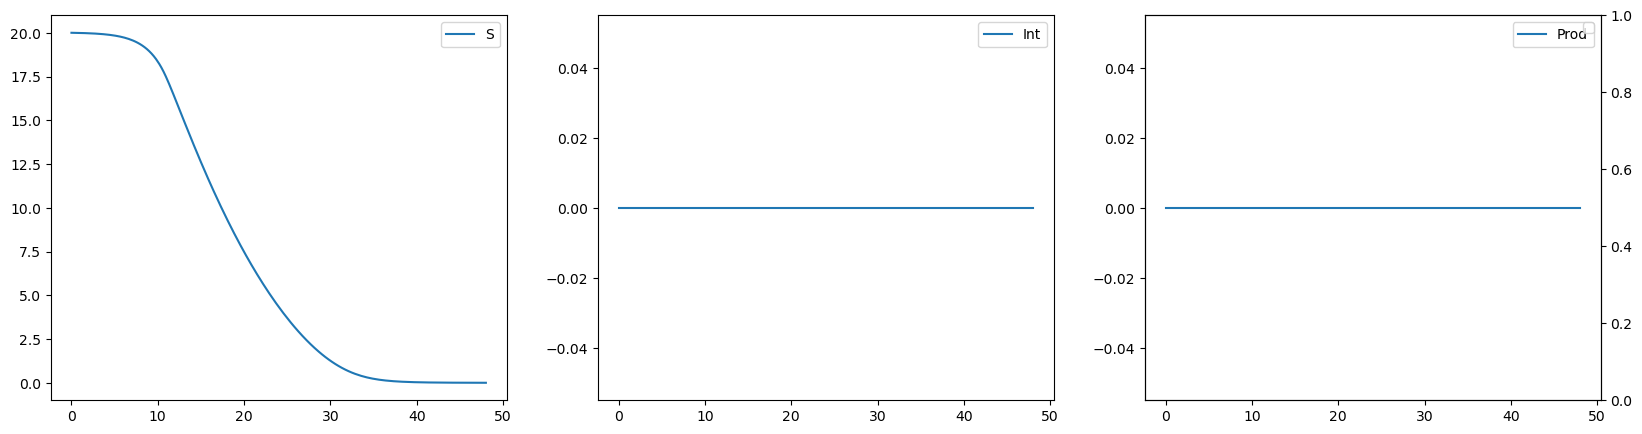

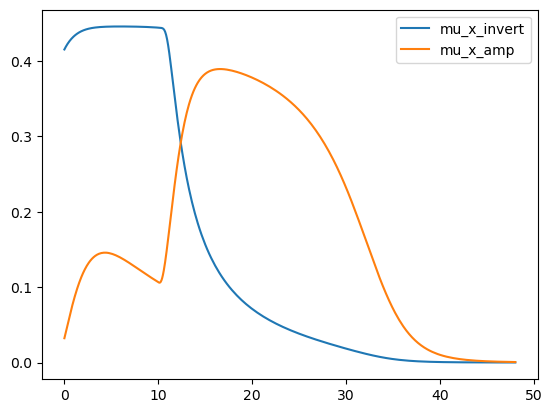

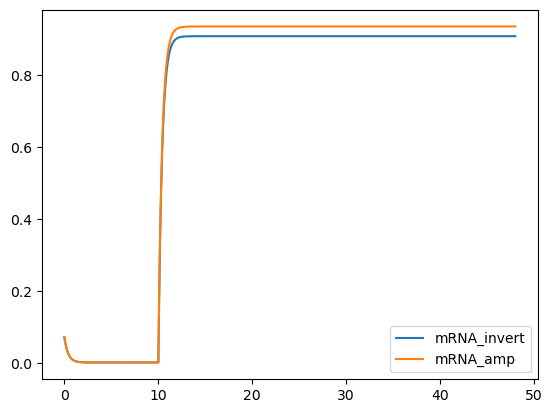

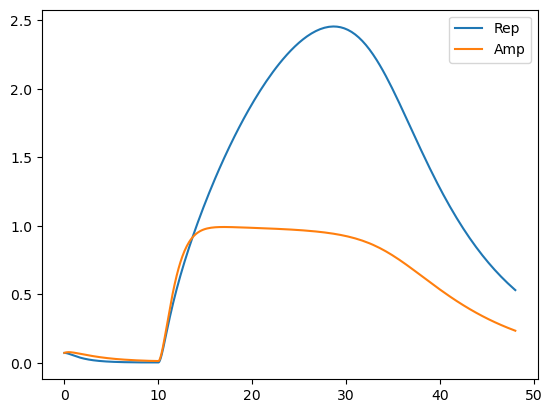

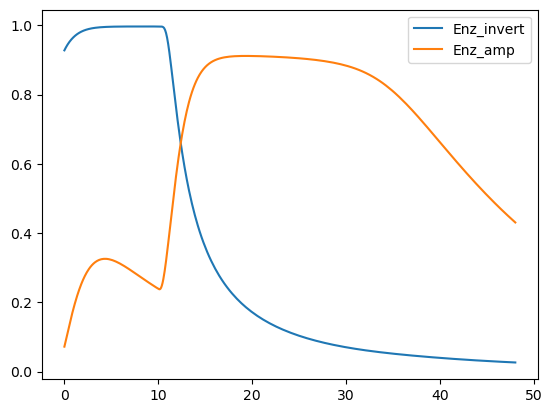

In [148]:
from scipy.interpolate import interp1d

# kdegR = 0.042116
# ktrans = 1.4514
# kdegP = 0.1
# K_Rep = 0.05
# K_Amp = 0.99
# n_Rep = 4
# n_Amp = 4
# kdegPPDC = 0

# mu_max_invert = 0.45 / 60
# mu_max_amp = 0.45 / 60

# # mu_max = mu_max_opto
# Ks = 1
# Y = 0.5


t_final = 48
t_switch = 10

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

# mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp

k_r1 = 0.0
K_r1 = 1
k_r2 = 0.0
K_r2 = 1
prod_p = k_r1, K_r1, k_r2, K_r2


# def opto_growth(t,x,p, control_p, u0, mRNA_funs, ratio_sp=None, od_sp=None):
K_P = 0
K_I = 0
K_D = 0
control_p = K_P, K_I, K_D

tspan = [0, t_final*60]

u0 = 0.00
mRNA_invert_fun = lambda  u: interp1d(u_arr, mRNA_arr_invert)(u)
mRNA_amp_fun = lambda  u: interp1d(u_arr, mRNA_arr_amp)(u)
mRNA_funs = mRNA_invert_fun, mRNA_amp_fun
od_sp = None
ratio_sp = None

X10 = 0.01
X20 = 1e-20
x_init = [u, u, u, u, 1-u, u, 20, 0, 0, X10, X20, X10/X20, 0]

period = 100 / 60
Imax = 1

setpoint_amp = steady_mRNA_solve(u0, period, Imax, p_scaled_amp, x_guess=setpoint_amp)
setpoint_invert = steady_mRNA_solve(u0, period, Imax, p_scaled_invert, x_guess=setpoint_invert)

# print('my setpoint')
# print(setpoint)

I = lambda t: I_fun_base(t, u, period, Imax)

if u0 > 0:
    max_step = u0*period
else:
    max_step = period / 10

tspan = [0, t_switch*60]
sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p, control_p, prod_p, u0, mRNA_funs, ratio_sp, od_sp),
                    rtol=1e-6, atol=1e-9, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0001,
                    # max_step=max_step,
                    )
x_init = sol.y[:,-1]

print(sol.status)
print(sol.message)
print(sol.success)

mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, Int_x, Prod_x, X_invert_x, X_amp_x, X1X2_ratio_x, I_x = sol.y

mRNA_invert = mRNA_invert_x
mRNA_amp = mRNA_amp_x
Rep = Rep_x
Amp = Amp_x
Enz_invert = Enz_invert_x
Enz_amp = Enz_amp_x
S = S_x
Int = Int_x
Prod = Prod_x
X_invert = X_invert_x
X_amp = X_amp_x
X1X2_ratio = X1X2_ratio_x
I = I_x
t_arr = sol.t

tspan = [t_switch*60, t_final*60]
u0 = 1.00
sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init, args=(optogrowth_p, control_p, prod_p, u0, mRNA_funs, ratio_sp, od_sp),
                    rtol=1e-6, atol=1e-9, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.0001,
                    # max_step=max_step,
                    )
x_init = sol.y[:,-1]

print(sol.status)
print(sol.message)
print(sol.success)

mRNA_invert_x, mRNA_amp_x, Rep_x, Amp_x, Enz_invert_x, Enz_amp_x, S_x, Int_x, Prod_x, X_invert_x, X_amp_x, X1X2_ratio_x, I_x = sol.y

mRNA_invert = np.concatenate((mRNA_invert, mRNA_invert_x))
mRNA_amp = np.concatenate((mRNA_amp, mRNA_amp_x))
Rep = np.concatenate((Rep, Rep_x))
Amp = np.concatenate((Amp, Amp_x))
Enz_invert = np.concatenate((Enz_invert, Enz_invert_x))
Enz_amp = np.concatenate((Enz_amp, Enz_amp_x))
S = np.concatenate((S, S_x))
Int = np.concatenate((Int, Int_x))
Prod = np.concatenate((Prod, Prod_x))
X_invert = np.concatenate((X_invert, X_invert_x))
X_amp = np.concatenate((X_amp, X_amp_x))
X1X2_ratio = np.concatenate((X1X2_ratio, X1X2_ratio_x))
I = np.concatenate((I, I_x))
t_arr = np.concatenate((t_arr, sol.t))

mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S) * 60
mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S) * 60

# u_plot = u0 + K_P * (X_invert/X_amp - ratio_sp(t_arr)) + K_I * I + K_D * dX1X2_ratio
# u_plot = np.clip(u_plot, -5, 0)
# u_plot = 10 ** u_plot

fig = plt.figure(facecolor='white', figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(t_arr/60, X_invert, label='X_invert')
ax.plot(t_arr/60, X_amp, label='X_amp')
plt.legend()
# ax = fig.add_subplot(122)
# ax.plot(t_arr/60, u_plot, 'r', label='u')

fig = plt.figure(facecolor='white', figsize=(15,5))
ax = fig.add_subplot(121)
ax.plot(t_arr/60, X_invert/X_amp, 'k-', label='X_invert')
# ax.plot(t_arr/60, ratio_sp(t_arr), 'g--', label='target')
plt.legend()
# ax = fig.add_subplot(122)
# ax.plot(t_arr/60, u_plot, 'r', label='u')

d = (mu_x_invert * X_invert + mu_x_amp * X_amp) / (X_invert + X_amp)
S0 = 20

fig = plt.figure(facecolor='white', figsize=(20,5))
ax = fig.add_subplot(131)
ax.plot(t_arr/60, S, label='S')
plt.legend()
# ax2 = ax.twinx()
# ax2.plot(t_arr/60, (S0-S)*d, 'r--', label='(S0-S)*d')
# ax.plot(t_arr/60, X_invert/X_amp, 'k-', label='Xinv/Xamp')
plt.legend()

ax = fig.add_subplot(132)
ax.plot(t_arr/60, Int, label='Int')
plt.legend()
# ax2 = ax.twinx()
# ax2.plot(t_arr/60, Int*d, 'r--', label='Int*d')
# ax.plot(t_arr/60, X_invert/X_amp, 'k-', label='Xinv/Xamp')
plt.legend()

ax = fig.add_subplot(133)
ax.plot(t_arr/60, Prod, label='Prod')
# ax.plot(t_arr/60, X_invert/X_amp, 'k-', label='Xinv/Xamp')
plt.legend()
ax2 = ax.twinx()
plt.legend()
# ax2.plot(t_arr/60, Prod*d, 'r--', label='Prod*d')
plt.legend()


plt.figure(facecolor='white')
plt.plot(t_arr/60, mu_x_invert, label='mu_x_invert')
plt.plot(t_arr/60, mu_x_amp, label='mu_x_amp')
plt.legend()


plt.figure(facecolor='white')
plt.plot(t_arr/60, mRNA_invert, label='mRNA_invert')
plt.plot(t_arr/60, mRNA_amp, label='mRNA_amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Rep, label='Rep')
plt.plot(t_arr/60, Amp, label='Amp')
plt.legend()

plt.figure(facecolor='white')
plt.plot(t_arr/60, Enz_invert, label='Enz_invert')
plt.plot(t_arr/60, Enz_amp, label='Enz_amp')
plt.legend()